# 📊 Sahte Haber Analizi - Detaylı Görselleştirmeler

Bu notebook'ta tüm grafikleri detaylı şekilde oluşturacağız.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Grafik ayarları
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Görselleştirme kütüphaneleri hazır!")

✅ Görselleştirme kütüphaneleri hazır!


In [2]:
# Veri yükleme
fake_news = pd.read_csv('../data/Fake.csv')
real_news = pd.read_csv('../data/True.csv')

fake_news['label'] = 0
real_news['label'] = 1
fake_news['type'] = 'Sahte'
real_news['type'] = 'Gerçek'

df = pd.concat([fake_news, real_news], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Metin uzunlukları
df['title_length'] = df['title'].str.len()
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"📊 Veri hazır: {df.shape[0]:,} haber")

📊 Veri hazır: 44,898 haber


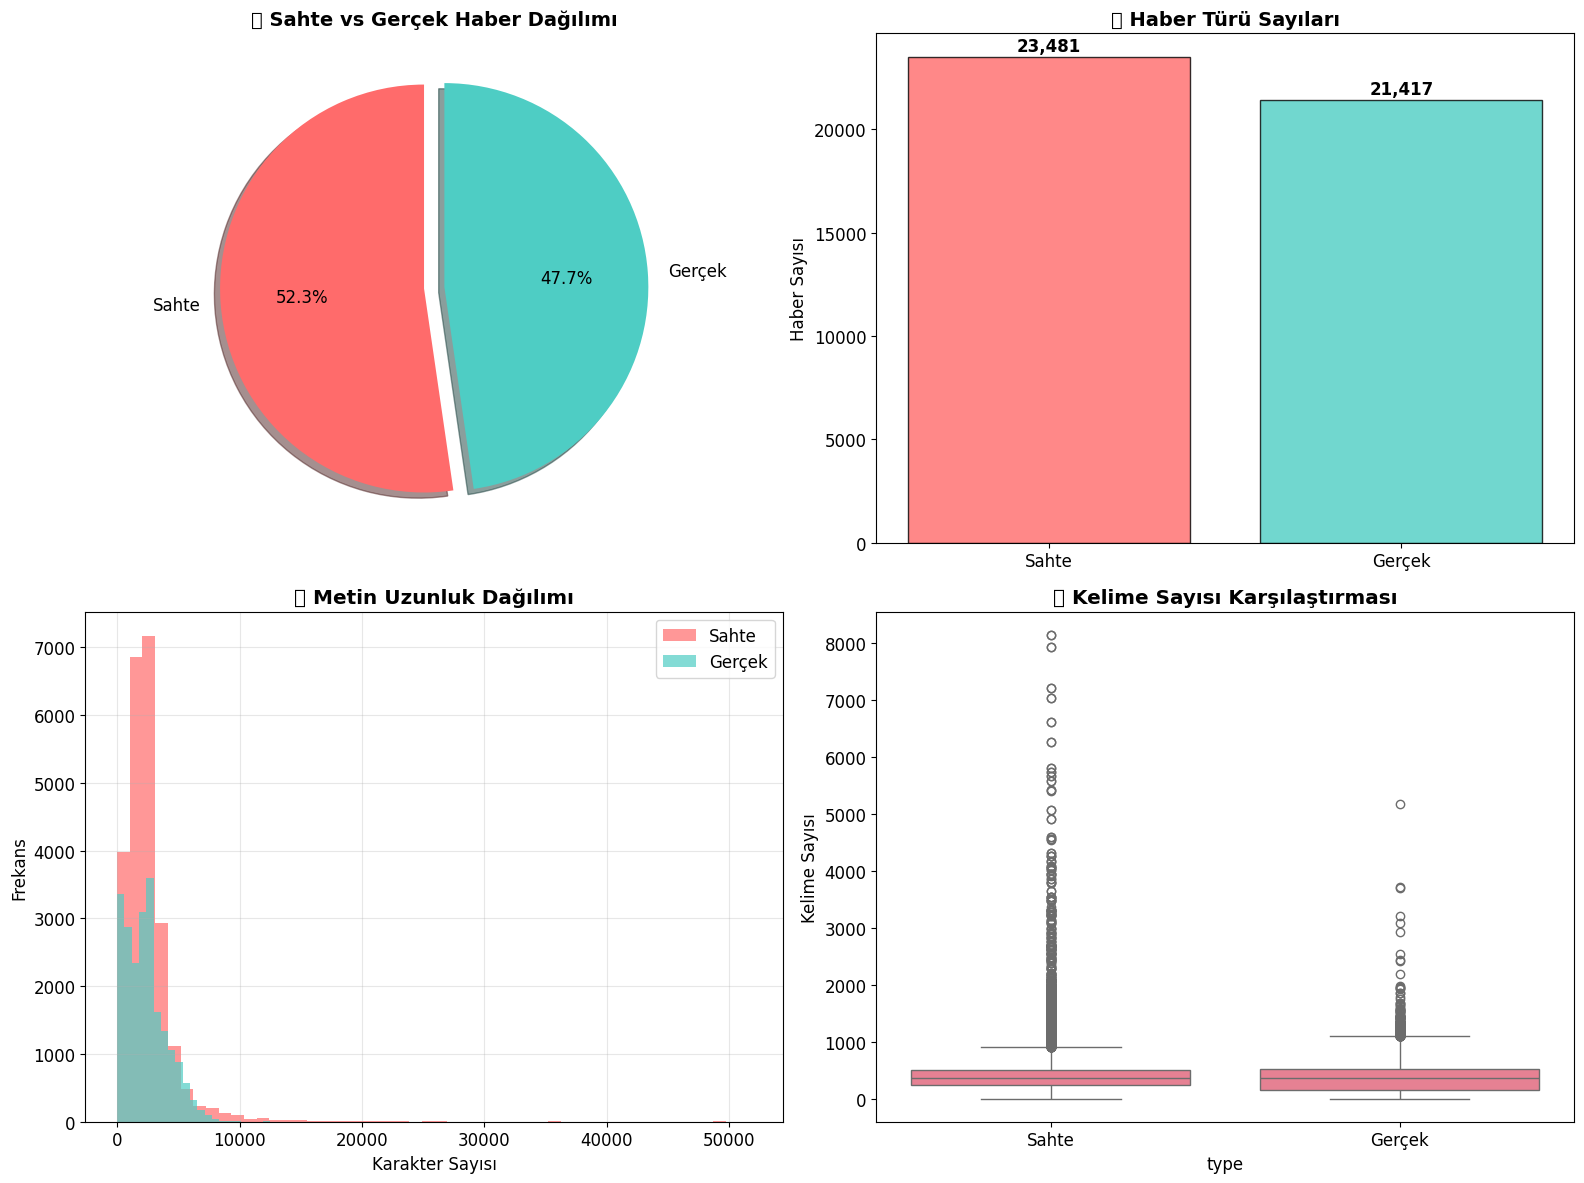

✅ Temel analizler tamamlandı


In [3]:
# 1. Ana Dağılım Grafikleri
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pasta grafiği
label_counts = df['type'].value_counts()
colors = ['#ff6b6b', '#4ecdc4']
wedges, texts, autotexts = axes[0,0].pie(label_counts.values, labels=label_counts.index, 
                                        autopct='%1.1f%%', colors=colors, startangle=90, 
                                        explode=(0.05, 0.05), shadow=True)
axes[0,0].set_title('📊 Sahte vs Gerçek Haber Dağılımı', fontsize=14, fontweight='bold')

# Bar grafiği
bars = axes[0,1].bar(label_counts.index, label_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0,1].set_title('📈 Haber Türü Sayıları', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Haber Sayısı')
for bar in bars:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 100,
                  f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Metin uzunluk karşılaştırması
axes[1,0].hist(df[df['type'] == 'Sahte']['text_length'], alpha=0.7, label='Sahte', bins=50, color='#ff6b6b')
axes[1,0].hist(df[df['type'] == 'Gerçek']['text_length'], alpha=0.7, label='Gerçek', bins=50, color='#4ecdc4')
axes[1,0].set_title('📄 Metin Uzunluk Dağılımı', fontweight='bold')
axes[1,0].set_xlabel('Karakter Sayısı')
axes[1,0].set_ylabel('Frekans')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Box plot
sns.boxplot(data=df, x='type', y='word_count', ax=axes[1,1])
axes[1,1].set_title('📦 Kelime Sayısı Karşılaştırması', fontweight='bold')
axes[1,1].set_ylabel('Kelime Sayısı')

plt.tight_layout()
plt.savefig('../analysis/temel_analizler.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Temel analizler tamamlandı")

📚 Konu analizi yapılıyor...


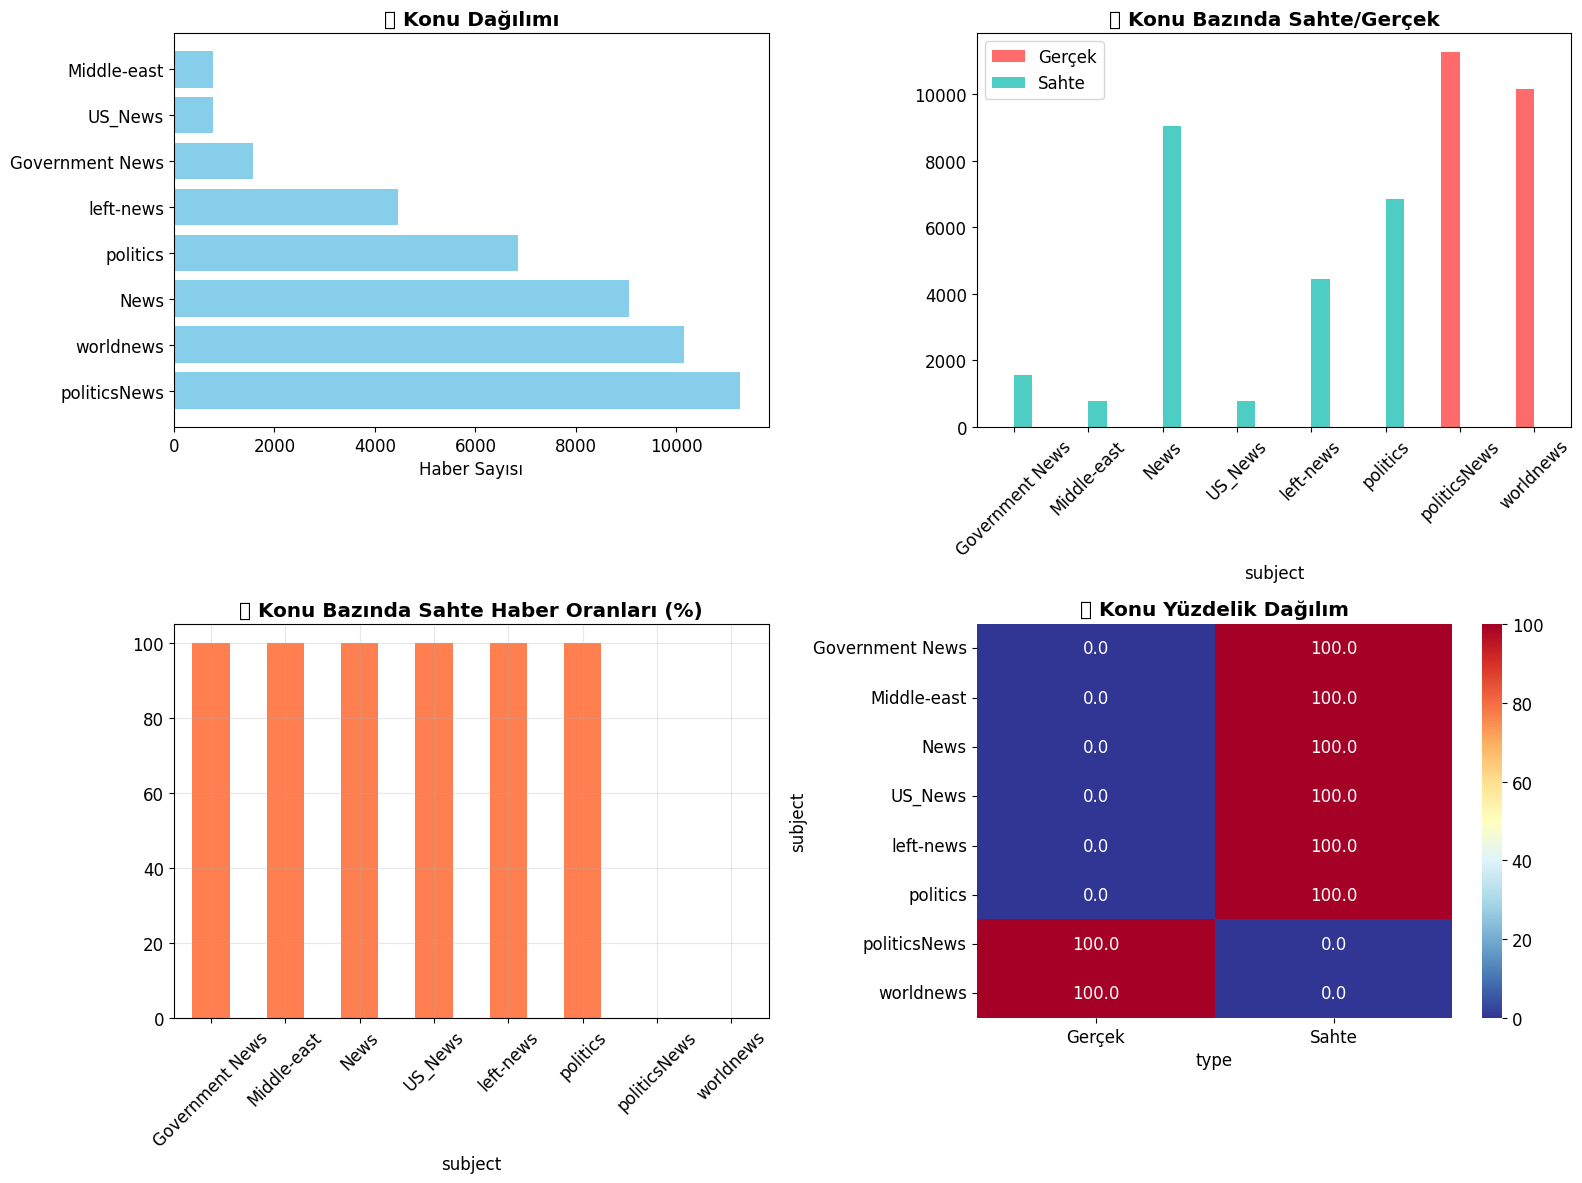

In [4]:
# 2. Konu Analizi (eğer subject sütunu varsa)
if 'subject' in df.columns:
    print("📚 Konu analizi yapılıyor...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Konu dağılımı
    subject_counts = df['subject'].value_counts()
    axes[0,0].barh(range(len(subject_counts)), subject_counts.values, color='skyblue')
    axes[0,0].set_yticks(range(len(subject_counts)))
    axes[0,0].set_yticklabels(subject_counts.index)
    axes[0,0].set_title('📚 Konu Dağılımı', fontweight='bold')
    axes[0,0].set_xlabel('Haber Sayısı')
    
    # Konu bazında sahte/gerçek
    subject_type = pd.crosstab(df['subject'], df['type'])
    subject_type.plot(kind='bar', ax=axes[0,1], color=['#ff6b6b', '#4ecdc4'])
    axes[0,1].set_title('📊 Konu Bazında Sahte/Gerçek', fontweight='bold')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend()
    
    # Sahte haber oranları
    fake_ratios = df.groupby('subject')['label'].apply(lambda x: (x == 0).mean() * 100)
    fake_ratios.plot(kind='bar', ax=axes[1,0], color='coral')
    axes[1,0].set_title('🎯 Konu Bazında Sahte Haber Oranları (%)', fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Heatmap
    subject_pct = pd.crosstab(df['subject'], df['type'], normalize='index') * 100
    sns.heatmap(subject_pct, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[1,1])
    axes[1,1].set_title('🔥 Konu Yüzdelik Dağılım', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../analysis/konu_analizi.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Subject sütunu bulunamadı")

In [5]:
# 3. İnteraktif Plotly Grafikleri
print("🎨 İnteraktif grafikler...")

# Scatter plot
fig = px.scatter(df.sample(5000), x='title_length', y='text_length', 
                color='type', title='📊 Başlık vs Metin Uzunluğu',
                color_discrete_map={'Sahte': '#ff6b6b', 'Gerçek': '#4ecdc4'})
fig.show()

# Histogram
fig = px.histogram(df, x='word_count', color='type', 
                  title='📈 Kelime Sayısı Dağılımı',
                  color_discrete_map={'Sahte': '#ff6b6b', 'Gerçek': '#4ecdc4'})
fig.show()

🎨 İnteraktif grafikler...
